<a href="https://colab.research.google.com/github/KieltRadek/Image_Recognition_CIFAR10/blob/main/Image_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# =========================================================
# --- Opcjonalnie : montowanie Google Drive ---
# =========================================================
from google.colab import drive
import os

# Montowanie dysku Google
drive.mount('/content/drive')

# Ścieżka do folderu roboczego na Drive
base_export_dir = '/content/drive/MyDrive/colab_cifar10_exports'
os.makedirs(base_export_dir, exist_ok=True)

print(f"[OK] Google Drive podłączony. Pliki będą zapisywane w:\n{base_export_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[OK] Google Drive podłączony. Pliki będą zapisywane w:
/content/drive/MyDrive/colab_cifar10_exports


In [17]:
# =========================================================
# --- 0. Import bibliotek ---
# =========================================================
import numpy as np
import matplotlib.pyplot as plt
import datetime

from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import (
    Input,
    Conv2D,
    BatchNormalization,
    Activation,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Flatten,
    Dense,
    Dropout
)
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Etykieta przykładowego obrazu: [6]


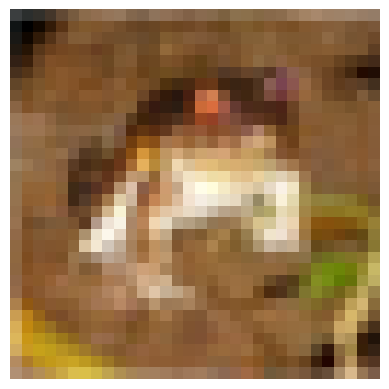

In [18]:
# =========================================================
# --- 1. Importowanie danych CIFAR10 ---
# =========================================================
# Wczytanie zbioru danych CIFAR10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Wyświetlenie przykładowego obrazu (opcjonalne)
print("Etykieta przykładowego obrazu:", y_train[0])
plt.imshow(x_train[0])
plt.axis('off')
plt.show()

In [19]:
# =========================================================
# --- 2. Wstępne przetwarzanie danych ---
# =========================================================
# Normalizacja do zakresu [0,1] i dodanie kanału (H,W,1)
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0

# One-hot encoding etykiet
num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)

# lista nazw klas CIFAR-10 (użyteczna w wyświetleniach)
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [20]:
# =========================================================
# --- 2.5 Data Augmentation ---
# =========================================================
# Augmentacja danych - znacząco poprawia generalizację modelu

datagen = ImageDataGenerator(
    rotation_range=15,           # losowe obroty do 15 stopni
    width_shift_range=0.1,       # przesunięcia w poziomie
    height_shift_range=0.1,      # przesunięcia w pionie
    horizontal_flip=True,        # odbicie lustrzane
    fill_mode='nearest',          # wypełnianie pustych pikseli
    zoom_range=0.1
)

datagen.fit(x_train)

In [21]:
# =========================================================
# --- 3. Definicja ULEPSZONEGO modelu sieci neuronowej ---
# =========================================================


input_shape = (32, 32, 3)  # CIFAR-10 to 32x32 RGB

model = Sequential([
    Input(shape=input_shape),


    # Blok 1 - zredukowany dropout
    Conv2D(32, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.2),

    # Blok 2
    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    # Blok 3
    Conv2D(128, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    # Klasyfikator - uproszczony
    Flatten(),
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])


In [22]:
# =========================================================
# --- 4. Kompilacja modelu ---
# =========================================================
# Optymalizator Adam, funkcja straty categorical_crossentropy, metryka accuracy
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

"""
Prawdziwa klasa: 3 (kot)
y_true = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

Predykcja modelu (DOBRA):
y_pred = [0.05, 0.02, 0.08, 0.75, 0.03, 0.02, 0.01, 0.01, 0.02, 0.01]
                            ↑ 75% pewności dla kota
"""

# Wyświetlenie podsumowania modelu
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 8, 8, 128)      │             

 Total params: 552,874 (2.11 MB)

 Trainable params: 551,722 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [23]:
# =========================================================
# --- 5. Trenowanie modelu ---
# =========================================================
# Ulepszone callbacki

"""es
Obserwuje val_loss po każdej epoce
Jeśli przez 10 epok loss nie spadnie o minimum 0.0001
Zatrzymuje trening i przywraca najlepsze wagi
"""

"""Po każdej epoce: Model zapisuje wagi do pamięci tymczasowej
Jeśli val_loss jest NAJNIŻSZY: "To są najlepsze wagi do tej pory!"
Po zakończeniu treningu: Przywróć wagi z epoki z najniższym val_loss
"""
es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.0001,
    mode='min',
    restore_best_weights=True,
    verbose=1
)
"""rlp
Jak działa:

Jeśli przez 5 epok brak poprawy
Zmniejsz LR o połowę (0.001 → 0.0005 → 0.00025...)
Nie idź poniżej 1e-7
"""
rlp = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_delta=0.0001,
    min_lr=1e-7,
    mode='min',
    verbose=1
)


BATCH_SIZE = 128

history = model.fit(
    datagen.flow(x_train, y_train_cat, batch_size=BATCH_SIZE),
    epochs=30,
    validation_data=(x_test, y_test_cat),
    callbacks=[es, rlp],
    verbose=1
)

ts = datetime.datetime.now().strftime("_%Y%m%d_%H%M")

Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 54s 110ms/step - accuracy: 0.3306 - loss: 1.8914 - val_accuracy: 0.2842 - val_loss: 2.4997 - learning_rate: 0.0010
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.5317 - loss: 1.2981 - val_accuracy: 0.5524 - val_loss: 1.3052 - learning_rate: 0.0010
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 86ms/step - accuracy: 0.6098 - loss: 1.0948 - val_accuracy: 0.6435 - val_loss: 1.0148 - learning_rate: 0.0010
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.6593 - loss: 0.9675 - val_accuracy: 0.6744 - val_loss: 0.9718 - learning_rate: 0.0010
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 85ms/step - accuracy: 0.6861 - loss: 0.8899 - val_accuracy: 0.7254 - val_loss: 0.7911 - learning_rate: 0.0010
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.7101 - loss: 0.8332 - val_accuracy: 0.7256 - val_loss: 0.7904 - learning_rate: 0.0010
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 85ms/step - accuracy: 0.7260 - 

In [24]:
# =========================================================
# --- 6. Ewaluacja modelu ---
# =========================================================
loss, accuracy = model.evaluate(x_test, y_test_cat, verbose=0)
print('Dokładność na zbiorze testowym:', f"{accuracy:.2f}")
print('Strata na zbiorze testowym:', f"{loss:.2f}")

Dokładność na zbiorze testowym: 0.85
Strata na zbiorze testowym: 0.47


Zapisano wykres loss/accuracy -> /content/drive/MyDrive/colab_cifar10_exports/training_loss_accuracy_20251124_1641.png


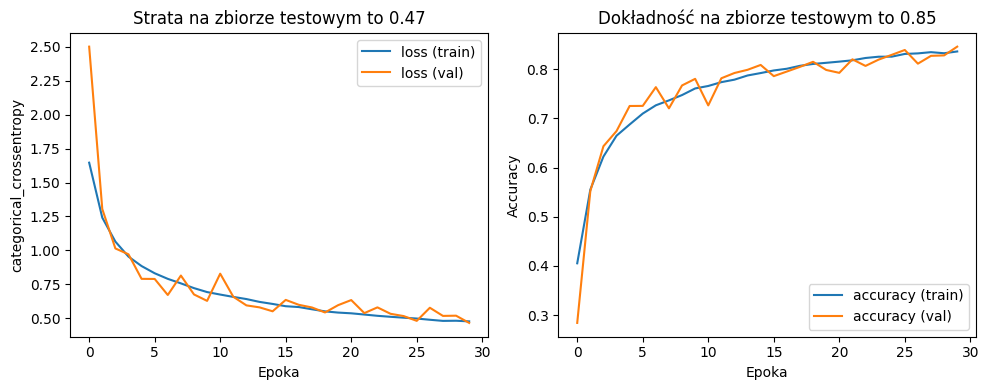

In [25]:
# =========================================================
# --- 7. Wizualizacja przebiegu treningu (loss) ---
# =========================================================
fig_loss_acc = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='loss (train)')
plt.plot(history.history['val_loss'], label='loss (val)')
plt.xlabel('Epoka')
plt.ylabel('categorical_crossentropy')
plt.title(f'Strata na zbiorze testowym to {loss:.2f}')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='accuracy (train)')
plt.plot(history.history['val_accuracy'], label='accuracy (val)')
plt.xlabel('Epoka')
plt.ylabel('Accuracy')
plt.title(f"Dokładność na zbiorze testowym to {accuracy:.2f}")
plt.legend()
plt.tight_layout()

# Zapis wykresu
loss_acc_path = os.path.join(base_export_dir, f'training_loss_accuracy{ts}.png')
fig_loss_acc.savefig(loss_acc_path)
print("Zapisano wykres loss/accuracy ->", loss_acc_path)

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


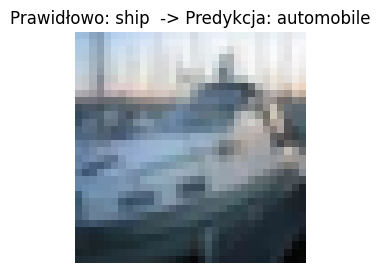

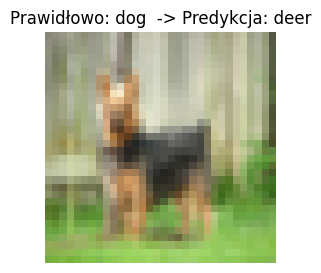

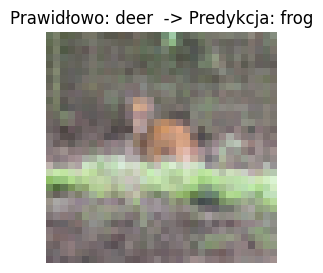

Zapisano macierz pomyłek -> /content/drive/MyDrive/colab_cifar10_exports/confusion_matrix_20251124_1641.png


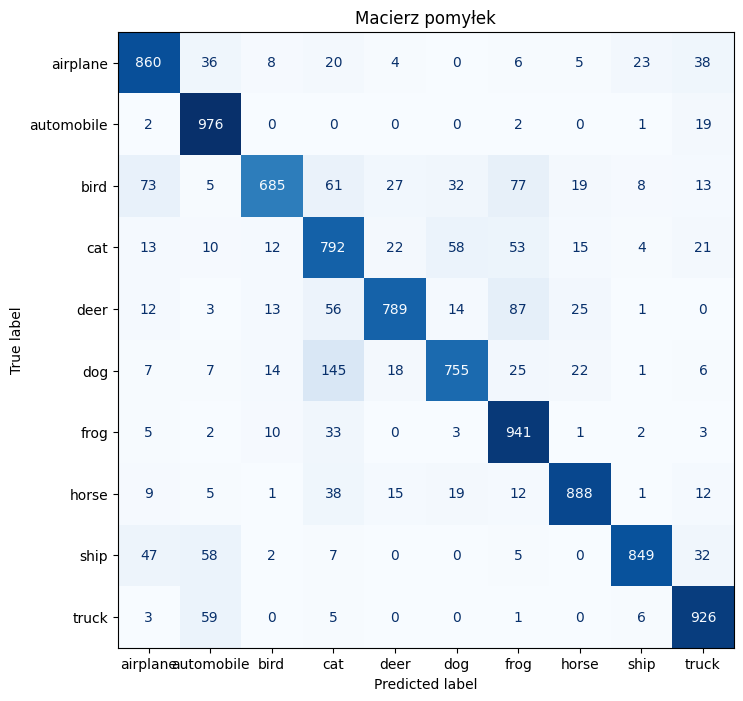

In [26]:
# =========================================================
# --- 8. Wizualizacja błędnych klasyfikacji i macierz pomyłek ---
# =========================================================
# Predykcje (etykiety)
pred_probs = model.predict(x_test)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = np.argmax(y_test_cat, axis=1)  # lub po prostu y_test

# Indeksy błędnych klasyfikacji
incorrect_indices = np.nonzero(pred_labels != true_labels)[0]

# Wyświetlenie kilku błędnych przykładów
n_show = min(3, len(incorrect_indices))
for i in range(n_show):
    idx = incorrect_indices[i]
    plt.figure(figsize=(3,3))
    plt.imshow(x_test[idx].squeeze(), cmap='gray')
    plt.title(f"Prawidłowo: {class_names[true_labels[idx]]}  -> Predykcja: {class_names[pred_labels[idx]]}")
    plt.axis('off')
    plt.show()

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig_cm, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title('Macierz pomyłek')
# Zapis wykresu
loss_acc_path = os.path.join(base_export_dir, f'confusion_matrix{ts}.png')
fig_cm.savefig(loss_acc_path)
print("Zapisano macierz pomyłek ->", loss_acc_path)
plt.show()


In [27]:
# =========================================================
# --- 9. Zapis modelu ---
# =========================================================
model_path = os.path.join(base_export_dir, f"my_model{ts}.keras")
model.save(model_path)
print("Model zapisany jako", model_path)

Model zapisany jako /content/drive/MyDrive/colab_cifar10_exports/my_model_20251124_1641.keras
